In [1]:
pwd

'/data2/mito_lineage/Analysis/peaks_expression/jan21_2021'

In [2]:
config_f = "config.yaml"

In [3]:
from src.utils.parse_config import read_config_file
from os.path import join, dirname
import pandas as pd
from glob import glob
config = read_config_file(config_f)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
config

{'global': 'PROJECT',
 'indir': '/data2/isshamie/mito_lineage/data/processed/mtscATAC/jan21_2021/MTblacklist',
 'experiment': 'jan21_2021',
 'genome': 'MTblacklist',
 'samples': ['J2', 'P2']}

### Load:
1. Raw cells barcode w qc info
2. filtered cells barcode list
3. Peak-by-cell sparse matrix
4. Peak gene annotations 
5. Graph clustering filtered cells cluster label
6. TF-by-cell sparse count matrix
7. TF labels

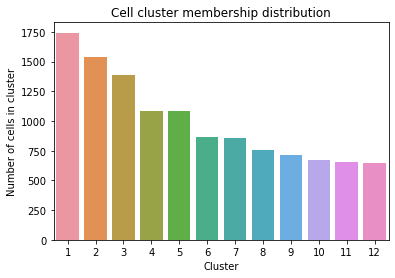

In [4]:
curr_in = join(config["indir"], config['samples'][0], 'outs')

### Create 1-based cell barcode index 

cells = pd.read_csv(join(curr_in,"singlecell.csv"))
cells

good_cells = cells[~(cells["cell_id"]=="None")].copy()
good_cells["ID"] = np.arange(1,len(good_cells)+1)
good_cells

cell_inds = pd.read_csv(join(curr_in, "filtered_peak_bc_matrix","barcodes.tsv"),header=None)
cell_inds

## Load peak annotations

peak_annotations = pd.read_csv(join(config["indir"], config['samples'][0], 'outs','peak_annotation.tsv'),sep='\t')
peak_annotations


### Load clusters

cluster_f = glob(join(config["indir"], config['samples'][0], 'outs','analysis',"clustering", "graphclust","clusters.csv"))
clusters_df = pd.read_csv(cluster_f[0])
clusters_df

%matplotlib inline
sns.countplot(clusters_df["Cluster"])
plt.title("Cell cluster membership distribution")
plt.ylabel("Number of cells in cluster")
plt.xlabel("Cluster")
## Load peaks matrix

filename = join(config['indir'],config['samples'][0],'outs','filtered_peak_bc_matrix/matrix.mtx')
peaks_sparse_mtx = pd.read_csv(filename,sep=' ',skiprows=2, header=None).iloc[1:]
peaks_sparse_mtx.columns = ["Peak", "Cell", "Count"]

In [5]:
cell_inds

,0
0,AAACGAAAGAGCTCCC-1
1,AAACGAAAGCGATACG-1
2,AAACGAAAGGCTTCGC-1
3,AAACGAAAGTACAACA-1
4,AAACGAACAACGTACT-1
...,...
12004,TTTGTGTTCGAGTTAC-1
12005,TTTGTGTTCGCATAAC-1
12006,TTTGTGTTCGTGGTAT-1
12007,TTTGTGTTCGTTACAG-1


In [6]:
clusters_df.head()

,Barcode,Cluster
0,AAACGAAAGAGCTCCC-1,2
1,AAACGAAAGCGATACG-1,7
2,AAACGAAAGGCTTCGC-1,5
3,AAACGAAAGTACAACA-1,1
4,AAACGAACAACGTACT-1,1


In [7]:
peaks_sparse_mtx

,Peak,Cell,Count
1,144263,1,2
2,144256,1,1
3,144184,1,2
4,144153,1,1
5,144028,1,1
...,...,...,...
31366827,354,12009,4
31366828,271,12009,2
31366829,257,12009,1
31366830,70,12009,2


# Annotate peak count matrix with gene name

In [8]:
peaks_sparse_mtx["Cluster"] = peaks_sparse_mtx["Cell"].apply(lambda x: clusters_df.loc[x-1,"Cluster"])
peaks_sparse_mtx

,Peak,Cell,Count,Cluster
1,144263,1,2,2
2,144256,1,1,2
3,144184,1,2,2
4,144153,1,1,2
5,144028,1,1,2
...,...,...,...,...
31366827,354,12009,4,2
31366828,271,12009,2,2
31366829,257,12009,1,2
31366830,70,12009,2,2


In [9]:
peaks_sparse_mtx["gene"] = peaks_sparse_mtx["Peak"].apply(lambda x: peak_annotations.loc[x-1,"gene"])

In [10]:
peaks_sparse_mtx

,Peak,Cell,Count,Cluster,gene
1,144263,1,2,2,IL9R
2,144256,1,1,2,VAMP7
3,144184,1,2,2,EMD
4,144153,1,1,2,HCFC1
5,144028,1,1,2,CXorf40B
...,...,...,...,...,...
31366827,354,12009,4,2,KLHL21
31366828,271,12009,2,2,NaN
31366829,257,12009,1,2,AJAP1
31366830,70,12009,2,2,CCNL2


## See the number of cells within a peak and number of peaks within a cell.

In [11]:
peaks_dense = peaks_sparse_mtx.pivot(index="Peak", columns="Cell",values="Count").fillna(0)
print((peaks_dense>0).sum())

Cell
1        4317
2        2033
3        3632
4        1286
5        2817
         ... 
12005    2624
12006    1339
12007    1481
12008    3992
12009    1965
Length: 12009, dtype: int64


Text(0.5, 1.0, 'Distribution of number of peaks seen in a cell across all cells')

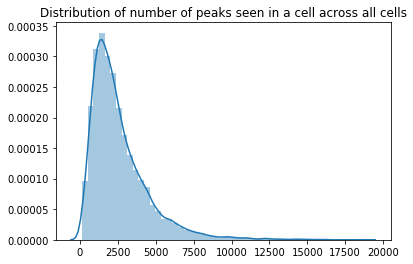

In [12]:
sns.distplot((peaks_dense>0).sum(axis=0))
plt.title("Distribution of number of peaks seen in a cell across all cells")

Text(0.5, 1.0, 'Distribution of the number of cells seen in a peak across all peaks')

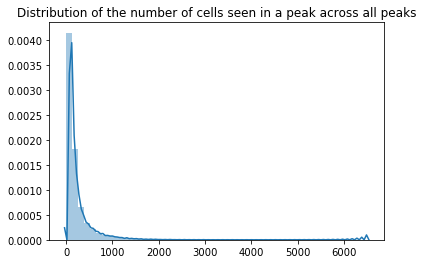

In [13]:
sns.distplot((peaks_dense>0).sum(axis=1))
plt.title("Distribution of the number of cells seen in a peak across all peaks")

## Look at CHIP mutations
- TP53
- U2AF1
- SF3B1
- SRSF2
- TET2
- IDH1
- IDH2  
TP53 and the splicing factor U2AF1 conferred the highest risk of AML development with hazard ratios of 12.5 and 7.9, respectively.16 This contrasts with hazard ratios for DNMT3A and TET2 of 1.4 and 1.6, respectively. In the study by Desai et al, mutations of TP53 and spliceosome genes (U2AF1, SF3B1,or SRSF2) also conferred a higher risk of AML development, with odds ratios of 47.2 and 7.4, respectively.17
They also identified IDH1, IDH2, and RUNX1 with PHF6 mutations as high-risk mutations. Re- markably, in this study, all persons with TP53 mutations (n 5 21) or IDH1/2 mutations (n 5 15) developed AML a median of 5 to 6 years from CH sampling.

In [14]:
chip_genes = ["TP53", "U2AF1", "SF3B1", "SRSF2", "TET2", "IDH1", "IDH2"]

In [15]:
chip_df = peak_annotations[peak_annotations["gene"].isin(chip_genes)]
chip_inds = peak_annotations[peak_annotations["gene"].isin(chip_genes)].index
chip_df["ID"] = chip_df.apply(lambda x: x["gene"]+"_"+x["peak_type"]+"_"+x["distance"],axis=1)
chip_df

/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,peak,gene,distance,peak_type,ID
23587,chr2_197378394_197378845,SF3B1,56182,distal,SF3B1_distal_56182
23588,chr2_197384108_197384681,SF3B1,50346,distal,SF3B1_distal_50346
23589,chr2_197387594_197388338,SF3B1,46689,distal,SF3B1_distal_46689
23590,chr2_197388942_197390096,SF3B1,44931,distal,SF3B1_distal_44931
23591,chr2_197391296_197391642,SF3B1,43385,distal,SF3B1_distal_43385
23592,chr2_197430781_197430842,SF3B1,4185,distal,SF3B1_distal_4185
23593,chr2_197431468_197431899,SF3B1,3128,distal,SF3B1_distal_3128
23594,chr2_197433709_197436375,SF3B1,0,promoter,SF3B1_promoter_0
23595,chr2_197442570_197444491,SF3B1,-7480,distal,SF3B1_distal_-7480
24239,chr2_208245752_208246210,IDH1,8112,distal,IDH1_distal_8112


In [28]:
(pd.merge(peaks_dense, chip_df[["ID"]], left_index=True, right_index=True).set_index("ID")>0).sum(axis=1)

ID
SF3B1_distal_56182      165
SF3B1_distal_50346      111
SF3B1_distal_46689       84
SF3B1_distal_44931      130
SF3B1_distal_43385      198
SF3B1_distal_4185        74
SF3B1_distal_3128        14
SF3B1_promoter_0         81
SF3B1_distal_-7480     1210
IDH1_distal_8112         20
IDH1_distal_3157         98
IDH1_promoter_0         282
TET2_distal_-178321     172
TET2_distal_-176158     553
TET2_distal_-169163      56
TET2_distal_-161774     123
TET2_distal_-130583     153
TET2_distal_-122163     441
TET2_distal_-119900     408
TET2_distal_-94854      103
TET2_distal_-91714        1
TET2_distal_-89958       88
TET2_distal_-83521       90
TET2_distal_-79894     2743
TET2_distal_-56859      233
TET2_distal_-38224      126
TET2_distal_-30982      248
TET2_distal_-28519      697
TET2_distal_-26050      300
TET2_distal_-24705      151
TET2_distal_-17240      256
TET2_distal_-16242      123
TET2_distal_-14046       63
TET2_distal_-9312        97
TET2_distal_-8131       374
TET2_distal_-4618

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


AttributeError: 'tuple' object has no attribute 'sum'

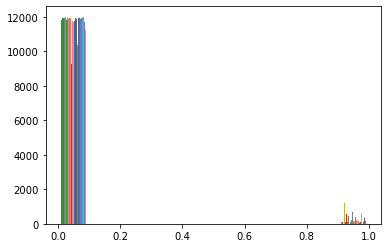

In [26]:
plt.hist(pd.merge(peaks_dense, chip_df[["ID"]], left_index=True, right_index=True).set_index("ID")>0).sum(axis=1)

In [22]:
chip_dist = (pd.merge(peaks_dense, chip_df[["ID"]], left_index=True, right_index=True)>0).sum(axis=1)
chip_dist

TypeError: '>' not supported between instances of 'str' and 'int'

In [ ]:
plt.hist(chip_dist

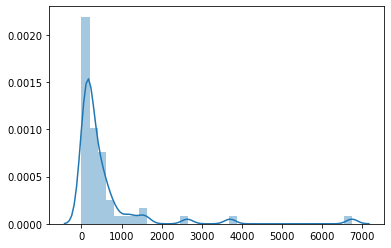

In [16]:
sns.distplot(pd.merge(peaks_dense, chip_df[["ID"]], left_index=True, right_index=True).set_index("ID").sum(axis=1))

## Look at how many T-cell annotated peaks (gene TRAC) were there and how many cells contained it

In [17]:
peak_annotations[peak_annotations["gene"] == "TRAC"]


,peak,gene,distance,peak_type
106644,chr14_22549907_22551963,TRAC,2402,distal
106645,chr14_22555210_22557756,TRAC,7705,distal
106646,chr14_22560663_22562367,TRAC,13158,distal


In [18]:
trac_peaks = peaks_sparse_mtx[peaks_sparse_mtx["gene"] == "TRAC"].groupby(["Peak", "Cell"]).size().reset_index().rename({0:"Count"},axis=1)

In [19]:
print("Number of cells for each peaks")
trac_peaks.groupby("Peak").size()

Number of cells for each peaks


Peak
106645     274
106646    1013
106647     431
dtype: int64

In [20]:
print("Number of cells with at least one peak")
print(trac_peaks.groupby("Peak").size())
print("\n")
print("Number Cells with at least one peak annotated as TRAC:")
print((trac_peaks.pivot("Cell", columns="Peak").fillna(0)>0).any(axis=1).sum())

Number of cells with at least one peak
Peak
106645     274
106646    1013
106647     431
dtype: int64


Number Cells with at least one peak annotated as TRAC:
1603
